## Introduction

The ongoing war between Israel and Hamas since October 7, 2023, has resulted in a devastating humanitarian crisis. More than 45,000 Palestinians have died. The lack of access to essential services, including clean water, electricity and medical care, has caused immense human suffering.

In order to help humanitarian workers and facilitate coordination in the impacted areas, there is an urgent need for **effective**, **low-cost** communication tool.

## Objective

The notebook aims to fine-tune Gemma model with two primary objective:
1. Improving its proficiency in Arabic, providing high-quality outputs.
2. Enhancing its translation capabilities between English and Arabic, specifically in the medical and engineering domains.

The pre-trained foundation model, **Gemma 2 - 2B** has been chosen, leveraging **low-rank adaptation (LoRA)** techinque to create low-cost, fast inference communication tool.

## Dataset

The first dataset chosen to improve Gemma 2’s proficiency in Arabic is **CIDAR**, provided by the Arabic Machine Learning non-profit group on Hugging Face. CIDAR is a culturally relevant instruction dataset which contains 10,000 instructions and outputs, licensed to use for research purpose.

The second dataset is designed to use for fine-tuning translation in spefic areas (medical and engineering), there is not specific dataset exist, so I need to create one myself, so this is also called distillation.

## Preconfiguration

In [1]:
!nvidia-smi

Sat Jan 11 06:19:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# install packages
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.7 MB/s eta 0:00:00


In [3]:
# load libraries
import keras
import keras_nlp
import time
import os
import matplotlib.pyplot as plt
from datasets import load_dataset

In [4]:
# configure environment

# operating system environment
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

# training environment
token_length_limit = 256
data_length_limit = 300
lora_name = "arbml_CIDAR"
lora_rank = 4
learning_rate = 4e-5
num_epochs = 20
model_id = "gemma2_instruct_2b_en"
batch_size = 1

## Model Initialization

In [5]:
# load Gemma model
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# functions for Gemma model
tick_start = 0
def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"Total time elapsed: {time.time() - tick_start}s")

def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma_lm.generate(input, max_length=token_length_limit)
    print("\nGemma Output:")
    print(output)
    tock()

In [7]:
# inference test
text_gen("Hi, nice to meet you! Introduce youself!")


Gemma Output:
<start_of_turn>user
Hi, nice to meet you! Introduce youself!<end_of_turn>
<start_of_turn>model
Hello! It's nice to meet you too. 😊 

I'm Gemma, an AI assistant created by the Gemma team. I'm a large language model, which means I'm really good at understanding and generating text.  

I can help you with things like:

* **Answering your questions:**  I've been trained on a massive amount of text data, so I can provide information on a wide range of topics.
* **Writing different kinds of creative content:**  I can help you write stories, poems, articles, and more.
* **Summarizing text:**  Give me a long piece of writing, and I can give you a concise summary.
* **Translating languages:**  I can translate text between many different languages.

What can I do for you today? 
<end_of_turn>
Total time elapsed: 35.239532232284546s


## Loading Dataset

In [8]:
# load dataset
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)
data_set = load_dataset(
    "arbml/CIDAR",
    split="train"
)

# print result
print("*" * 50)
print("Dataset insight:")
print(data_set)

README.md:   0%|          | 0.00/5.36k [00:00<?, ?B/s]

(…)-00000-of-00001-b2881e1b9f14c3b1.parquet:   0%|          | 0.00/3.55M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

**************************************************
Dataset insight:
Dataset({
    features: ['output', 'instruction', 'index'],
    num_rows: 10000
})


In [9]:
# format dataset type to Numpy for fast computation
data_set = data_set.with_format("np", columns=["output", "instruction"], output_all_columns=False)

# print result
print("*" * 50)
print("Dataset examples:")
print(data_set[:1])

**************************************************
Dataset examples:
{'output': array(['| الضمير | الماضي | المضارع | اسم الفاعل | اسم المفعول |\r\n|--------|--------|---------|-----------|------------|\r\n| هو     | أَجارَ  | يُجِيرُ   | مُجِير     | مُجَار      |\r\n| هي     | أَجارَتْ | تُجِيرُ   | مُجِيرَة   | مُجَارَة    |\r\n| هما   | أَجارَا  | يُجِيرانِ | مُجِيرانِ  | مُجَارانِ  |\r\n| هما   | أَجارَتَا | تُجِيرانِ | مُجِيرَتانِ| مُجَارَتانِ|\r\n| هم    | أَجارُوا | يُجِيرُونَ | مُجِيرُونَ | مُجَارُونَ  |\r\n| هنّ   | أَجرْنَ  | يُجِرْنَ  | مُجِيرات   | مُجَارات    |\r\n'],
      dtype='<U481'), 'instruction': array(['صغ من الفعل الاجوف أجَارَ\xa0 اسم الفاعل و اسم المفعول للضمائر هو هي هما هم هن.'],
      dtype='<U76')}


In [10]:
# create training data (strings) using dataset
training_data = []

for row in data_set:
    # training data
    prefix_text = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n'
    item = f"<start_of_turn>user\n{prefix_text}{row['instruction']}<end_of_turn>\n<start_of_turn>model\n{row['output']}<end_of_turn>"

    # limit the length of tokens of each item
    token_length = len(tokenizer(item))
    if token_length > token_length_limit:
        continue 
    else:
        training_data.append(item) 

    # limit the length of 
    data_length = len(training_data)
    if data_length >= data_length_limit:
            break

In [11]:
# test results 
print("*" * 50)
print("The length of training data:")
print(len(training_data))

print("*" * 50)
print("Example:")
print(training_data[0])

**************************************************
The length of training data:
300
**************************************************
Example:
<start_of_turn>user
Below is an instruction that describes a task. Write a response that appropriately completes the request.

 اشرح لي لماذا يجب على شخص يريد إعادة تدوير كتبه القديمة التبرع بها لمكتبة.<end_of_turn>
<start_of_turn>model
 التبرع بالكتب القديمة إلى المكتبة هو وسيلة ممتازة لإعادة تدويرها ومساعدة المجتمع. فالمكتبات لا تجعل الكتب متاحة للإعارة والاستمتاع فحسب، بل إنها غالبًا ما تستخدم عائدات التبرعات بالكتب لشراء لوازم جديدة والحفاظ على تحديث مجموعاتها. وعلاوة على ذلك، يساعد التبرع بالكتب على تقليل النفايات في المزابل، حيث إن العديد من الكتب التي لا يتم بيعها لمراكز إعادة التدوير تنتهي في المزابل.<end_of_turn>


## LoRA Fine-tuning

In [12]:
# enable LoRA on Gemma model
gemma_lm.backbone.enable_lora(rank=lora_rank) # a LoRA rank of 4 is computationally efficient
gemma_lm.preprocessor.sequence_length = token_length_limit

# use AdamW optimizer, which is common for transformer models
optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate,
    weight_decay = 0.01
)
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

# compile the model
gemma_lm.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = optimizer,
    weighted_metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

In [13]:
# define a custom callback to save LoRA weights and evaluate the model
class SaveLoRACallback(keras.callbacks.Callback):
    def __init__(self, lora_base_name, lora_rank_value):
        super().__init__()
        self.lora_base_name = lora_base_name
        self.lora_rank_value = lora_rank_value
        
    def on_epoch_end(self, epoch, logs=None):
        # save LoRA weights
        lora_file_name = f"/kaggle/working/{self.lora_base_name}_lora_rank{self.lora_rank_value}_epoch{epoch+1}.lora.h5"
        gemma_lm.backbone.save_lora_weights(lora_file_name)
        print(f"LoRA weights saved: {lora_file_name}")
        
        # evaluate the model
        # self.evaluate_model()
    
    def evaluate_model(self):
        text_gen("sample...")

In [14]:
# train the model
training_history = gemma_lm.fit(
    training_data,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[SaveLoRACallback(lora_base_name=lora_name, lora_rank_value=lora_rank)]
)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 1.6745 - sparse_categorical_accuracy: 0.5137LoRA weights saved: /kaggle/working/arbml_CIDAR_lora_rank4_epoch1.lora.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 202s 423ms/step - loss: 1.6739 - sparse_categorical_accuracy: 0.5138
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 1.0434 - sparse_categorical_accuracy: 0.6325LoRA weights saved: /kaggle/working/arbml_CIDAR_lora_rank4_epoch2.lora.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 127s 423ms/step - loss: 1.0436 - sparse_categorical_accuracy: 0.6324
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 0.9564 - sparse_categorical_accuracy: 0.6519LoRA weights saved: /kaggle/working/arbml_CIDAR_lora_rank4_epoch3.lora.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 127s 424ms/step - loss: 0.9566 - sparse_categorical_accuracy: 0.6519
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 0.9211 - sparse_categorical_accuracy: 0.6593LoRA weights saved: /kaggle/working/arbml_CIDAR_lora_rank4_e

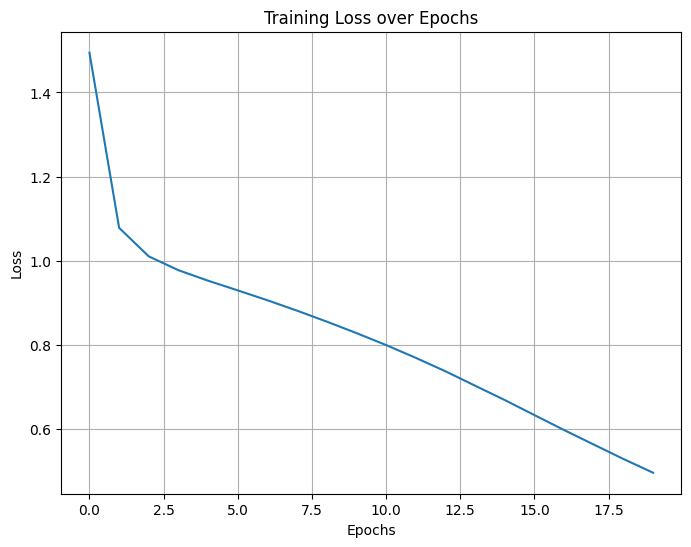

In [15]:
# plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(training_history.history['loss'], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()